In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular
%matplotlib inline
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [2]:
#------------------------------------------------------------
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

[========================================]  114.85Mb / 114.85Mb   


In [3]:
# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print "data size:"
print "  red gals: ", len(data_red)
print "  blue gals:", len(data_blue)

data size:
  red gals:  38017
  blue gals: 16883


In [4]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

@pickle_results: computing results and saving to 'correlation_functions.pkl'


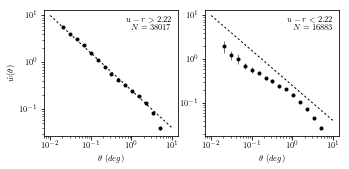

In [5]:
#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()

In [6]:
corr

[array([ 5.80964513,  4.10388456,  3.07021431,  2.30839326,  1.61804519,
         1.14809237,  0.79113056,  0.56845657,  0.42891209,  0.3213433 ,
         0.23869431,  0.18770874,  0.13359044,  0.08228449,  0.03949176]),
 array([ 1.98647518,  1.2535259 ,  1.043153  ,  0.70981181,  0.56735277,
         0.49987973,  0.36990619,  0.32173327,  0.2407058 ,  0.21295028,
         0.15638198,  0.10671161,  0.07297672,  0.04505819,  0.02687428])]

In [7]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure is an example from astroML: see http://astroML.github.com
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_sdss_specgals

data = fetch_sdss_specgals()

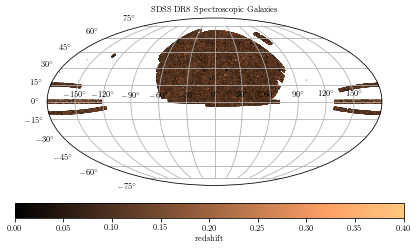

In [8]:
#------------------------------------------------------------
# plot the RA/DEC in an area-preserving projection

RA = data['ra']
DEC = data['dec']

# convert coordinates to degrees
RA -= 180
RA *= np.pi / 180
DEC *= np.pi / 180

ax = plt.axes(projection='mollweide')

ax = plt.axes()
ax.grid()
plt.scatter(RA, DEC, s=1, lw=0, c=data['z'], cmap=plt.cm.copper,
            vmin=0, vmax=0.4)

plt.title('SDSS DR8 Spectroscopic Galaxies')
cb = plt.colorbar(cax=plt.axes([0.05, 0.1, 0.9, 0.05]),
                  orientation='horizontal',
                  ticks=np.linspace(0, 0.4, 9))
cb.set_label('redshift')

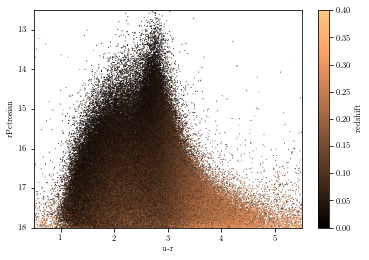

In [9]:
#------------------------------------------------------------
# plot the r vs u-r color-magnitude diagram
u = data['modelMag_u']
r = data['modelMag_r']
rPetro = data['petroMag_r']

plt.figure()
ax = plt.axes()
plt.scatter(u - r, rPetro, s=1, lw=0, c=data['z'], cmap=plt.cm.copper,
            vmin=0, vmax=0.4)
plt.colorbar(ticks=np.linspace(0, 0.4, 9)).set_label('redshift')

plt.xlim(0.5, 5.5)
plt.ylim(18, 12.5)

plt.xlabel('u-r')
plt.ylabel('rPetrosian')

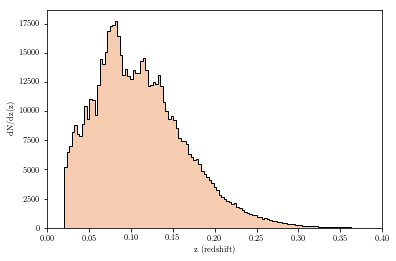

In [10]:
#------------------------------------------------------------
# plot a histogram of the redshift
from astroML.plotting import hist

plt.figure()
hist(data['z'], bins='knuth',
     histtype='stepfilled', ec='k', fc='#F5CCB0')
plt.xlim(0, 0.4)
plt.xlabel('z (redshift)')
plt.ylabel('dN/dz(z)')

plt.show()

In [ ]:
#Now refer to galaxy angular correlation functions and power spectrum from two micron all sky survey by AH Maller DH McIntosh N Katz

In [12]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure is an example from astroML: see http://astroML.github.com
import numpy as np
from matplotlib import pyplot as plt

# warning: due to a bug in healpy, importing it before pylab can cause
#  a segmentation fault in some circumstances.
import healpy as hp

from astroML.datasets import fetch_wmap_temperatures


#------------------------------------------------------------
# Fetch the data
wmap_unmasked = fetch_wmap_temperatures(masked=False)
wmap_masked = fetch_wmap_temperatures(masked=True)
white_noise = np.ma.asarray(np.random.normal(0, 0.062, wmap_masked.shape))

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


ValueError: total size of new array must be unchanged

In [ ]:
#------------------------------------------------------------
# plot the unmasked map
fig = plt.figure(1)
hp.mollview(wmap_unmasked, min=-1, max=1, title='Unmasked map',
            fig=1, unit=r'$\Delta$T (mK)')

In [ ]:
#------------------------------------------------------------
# plot the masked map
#  filled() fills the masked regions with a null value.
fig = plt.figure(2)
hp.mollview(wmap_masked.filled(), title='Masked map',
            fig=2, unit=r'$\Delta$T (mK)')

In [ ]:
#------------------------------------------------------------
# compute and plot the power spectrum
cl = hp.anafast(wmap_masked.filled(), lmax=1024)
ell = np.arange(len(cl))

cl_white = hp.anafast(white_noise, lmax=1024)

fig = plt.figure(3)
ax = fig.add_subplot(111)
ax.scatter(ell, ell * (ell + 1) * cl,
           s=4, c='black', lw=0,
           label='data')
ax.scatter(ell, ell * (ell + 1) * cl_white,
           s=4, c='gray', lw=0,
           label='white noise')

ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1)C_\ell$')
ax.set_title('Angular Power (not mask corrected)')
ax.legend(loc='upper right')
ax.grid()
ax.set_xlim(0, 1100)

plt.show()